# Evolutionary Algorithms for Combinatorial Multi-Knapsack
## EA Functions
### Imports and Config

In [292]:
import time, array, random, copy, math, sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from deap import algorithms, base, benchmarks, tools, creator
from deap.benchmarks.tools import hypervolume
import seaborn
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seaborn.set(style='whitegrid')
seaborn.set_context('notebook')
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

### Instance Creation

In [4]:
def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst
def instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate, sample_num):
    with open(file_name) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0].strip()
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d
def develop_instance_list(m, num_gen, samples):
    files = os.listdir("./Project_Data_Sets")
    file_templates = ['jeu_100_25_', 'jeu_100_50_', 'jeu_100_75_', 'jeu_100_100_',
                      'jeu_200_25_', 'jeu_200_50_', 'jeu_200_75_', 'jeu_200_100_',
                      'jeu_300_25_', 'jeu_300_50_']
    mutations = [.025, .05, .075, .1]
    xovers = [.2, .5, .8]
    populations = [100, 150, 200]
    instances = []
    for i in range(samples):
        for file_template in file_templates:
            j = random.randint(1,10)
            file_name = "./Project_Data_Sets/" + file_template + str(j) + ".txt"
            for mut_rate in mutations:
                for pop_size in populations:
                    for xover_rate in xovers:
                        instance = instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate, i+1)
                        instances.append(instance)
    return instances

In [5]:
%time instances = develop_instance_list(3, 200, 1)

Wall time: 8.79 s


### Population Generation, Fitness, Mutation, and Xover

In [222]:
def eval_fitness(individual, instance):
    n_kp = instance.get("n_kp")
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*n_kp
    knapsacks_profit = [0]*n_kp
    
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] <= n_kp:
            knapsack = individual[i] - 1
            knapsacks_weight[knapsack] += weights[i]
            knapsacks_profit[knapsack] += profits[i]
            for j in range(len(individual)):
                if knapsack == individual[n_kp-j] - 1:
                    knapsacks_profit[knapsack] += combinations[i-1][n_kp-j-1]
                if i == j:
                    break;
    f1 = 0
    f2 = sum(knapsacks_weight)
    f3 = max(knapsacks_profit)+1
    for i in range(n_kp):
        if knapsacks_weight[i] > capacity:
            temp = knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            temp = knapsacks_profit[i]
        f1 += temp
        if temp < f3:
            f3 = temp
    return f1, f2, f3

def uniform(low, m, n_kp):
    n = [0]*m
    for i in range(0,m):
        n[i] = random.randint(0,n_kp)
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x, n_kp):
    index = random.randrange(len(x))
    var = random.randint(0,n_kp)
    x[index] = var
    return x,



In [274]:
def varAnd(population, toolbox, cxpb, mutpb):
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

    return offspring
    
def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)
    
    # Begin the generational process
    counter = 0
    tmp = 0
    for gen in range(1, ngen + 1):
        # Select the next generation indivziduals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        max_fit = record.get("max")
        if max_fit == tmp:
            counter += 1
        else:
            counter = 0
        if counter == 10:
            break;
        
        tmp = max_fit
        
        if verbose:
            print(logbook.stream)

    return population, logbook

### Running EA

In [252]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = eaSimple(pop, toolbox,
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

### Single Execution Script

In [335]:
def execute_EA(instance, verbose = False):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0, 1.0))
    creator.create("Individual", list, typecode='i', 
                   fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    num_kp = instance.get("n_kp")
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", favorite_child_xover)
    toolbox.register("mutate", lambda x: mutation(x, num_kp),)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = instance.get("pop_size")
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    if verbose: 
        res,logbook = run_ea(toolbox)
    else:
        with HiddenPrints():
            res,logbook = run_ea(toolbox)
    fronts = [tools.emo.sortLogNondominated(res, len(res), first_front_only=True)]
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
#     fig = plt.figure(figsize=(15,10))
#     ax1 = fig.add_subplot(2, 2, 1, projection='3d')
#     ax2 = fig.add_subplot(2, 2, 2)
#     ax3 = fig.add_subplot(2, 2, 3)
#     ax4 = fig.add_subplot(2, 2, 4) #uncomment for subplots instead of separate plots 
    fig1 = plt.figure(figsize=(15,10))
    fig2 = plt.figure(figsize=(15,10))
    fig3 = plt.figure(figsize=(15,10))
    fig4 = plt.figure(figsize=(15,10))
    ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
    ax2 = fig2.add_subplot(1, 1, 1)
    ax3 = fig3.add_subplot(1, 1, 1)
    ax4 = fig4.add_subplot(1, 1, 1)
    
    st_front = []
    hv = []
    for i,inds in enumerate(fronts):
        hv.append(hypervolume(inds))
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df = df.rename(columns={0: "f1", 1: "f2", 2: "f3"})
        ax1.scatter3D(df.f1, df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax2.scatter(df.f1, df.f2, label='Front'+str(i+1), color=plot_colors[i])
        ax3.scatter(df.f1, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax4.scatter(df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        st_front.append(df)
    ax1.legend();ax2.legend();ax3.legend();ax4.legend()
    ax1.set_xlabel('$f_1(\mathbf{x})$');ax1.set_ylabel('$f_2(\mathbf{x})$');ax1.set_zlabel('$f_3(\mathbf{x})$')
    ax2.set_xlabel('$f_1(\mathbf{x})$');ax2.set_ylabel('$f_2(\mathbf{x})$')
    ax3.set_xlabel('$f_1(\mathbf{x})$');ax3.set_ylabel('$f_3(\mathbf{x})$')
    ax4.set_xlabel('$f_2(\mathbf{x})$');ax4.set_ylabel('$f_3(\mathbf{x})$')

    fig1.savefig('temp1.png', dpi=fig1.dpi)
    fig2.savefig('temp2.png', dpi=fig2.dpi)
    fig3.savefig('temp3.png', dpi=fig3.dpi)
    fig4.savefig('temp4.png', dpi=fig4.dpi)
    
   
    
    stat_dict = {'instance_name': instance.get('ref'),
             'sample_num': instance.get('sample_num'),
             'xover_rate': instance.get('xover_rate'),
             'mut_rate': instance.get('mut_rate'),
             'pop_size': instance.get('pop_size'),
             'num_gen': instance.get('num_gen'),
             'n_kp': instance.get('n_kp'),
             'mean_f1' : np.mean(st_front[0].f1),
             'median_f1' : np.median(st_front[0].f1),
             'variance_f1': np.var(st_front[0].f1), 
             'sample_size': len(st_front[0].f1), 
             'min_f1': min(st_front[0].f1),
             'max_f1': max(st_front[0].f1),
             'mean_f2' : np.mean(st_front[0].f2),
             'median_f2' : np.median(st_front[0].f2),
             'variance_f2': np.var(st_front[0].f2),
             'sample_size': len(st_front[0].f2),
             'min_f2': min(st_front[0].f2),
             'max_f2': max(st_front[0].f2),
             'mean_f3' : np.mean(st_front[0].f3),
             'median_f3' : np.median(st_front[0].f3),
             'variance_f3': np.var(st_front[0].f3),
             'sample_size': len(st_front[0].f3),
             'min_f3': min(st_front[0].f3),
             'max_f3': max(st_front[0].f3)}
    return res,logbook, fronts, stat_dict

### Multiple Instance Testing Function

In [250]:
### TODO: Make this function

## Running and Testing
### Single Execution

[206955328.0372683]
CPU times: user 844 ms, sys: 85.7 ms, total: 930 ms
Wall time: 937 ms


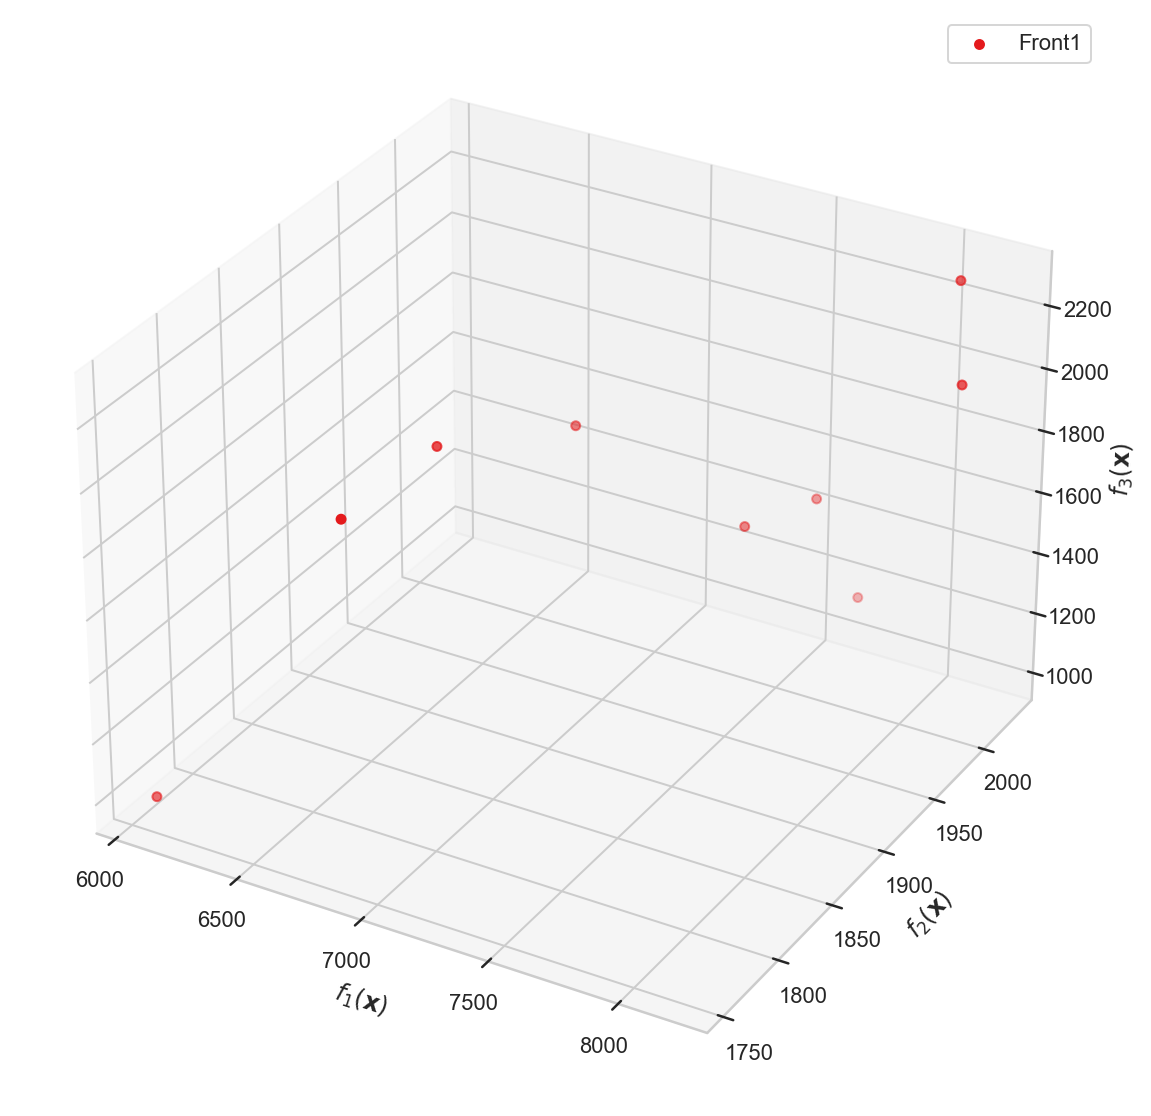

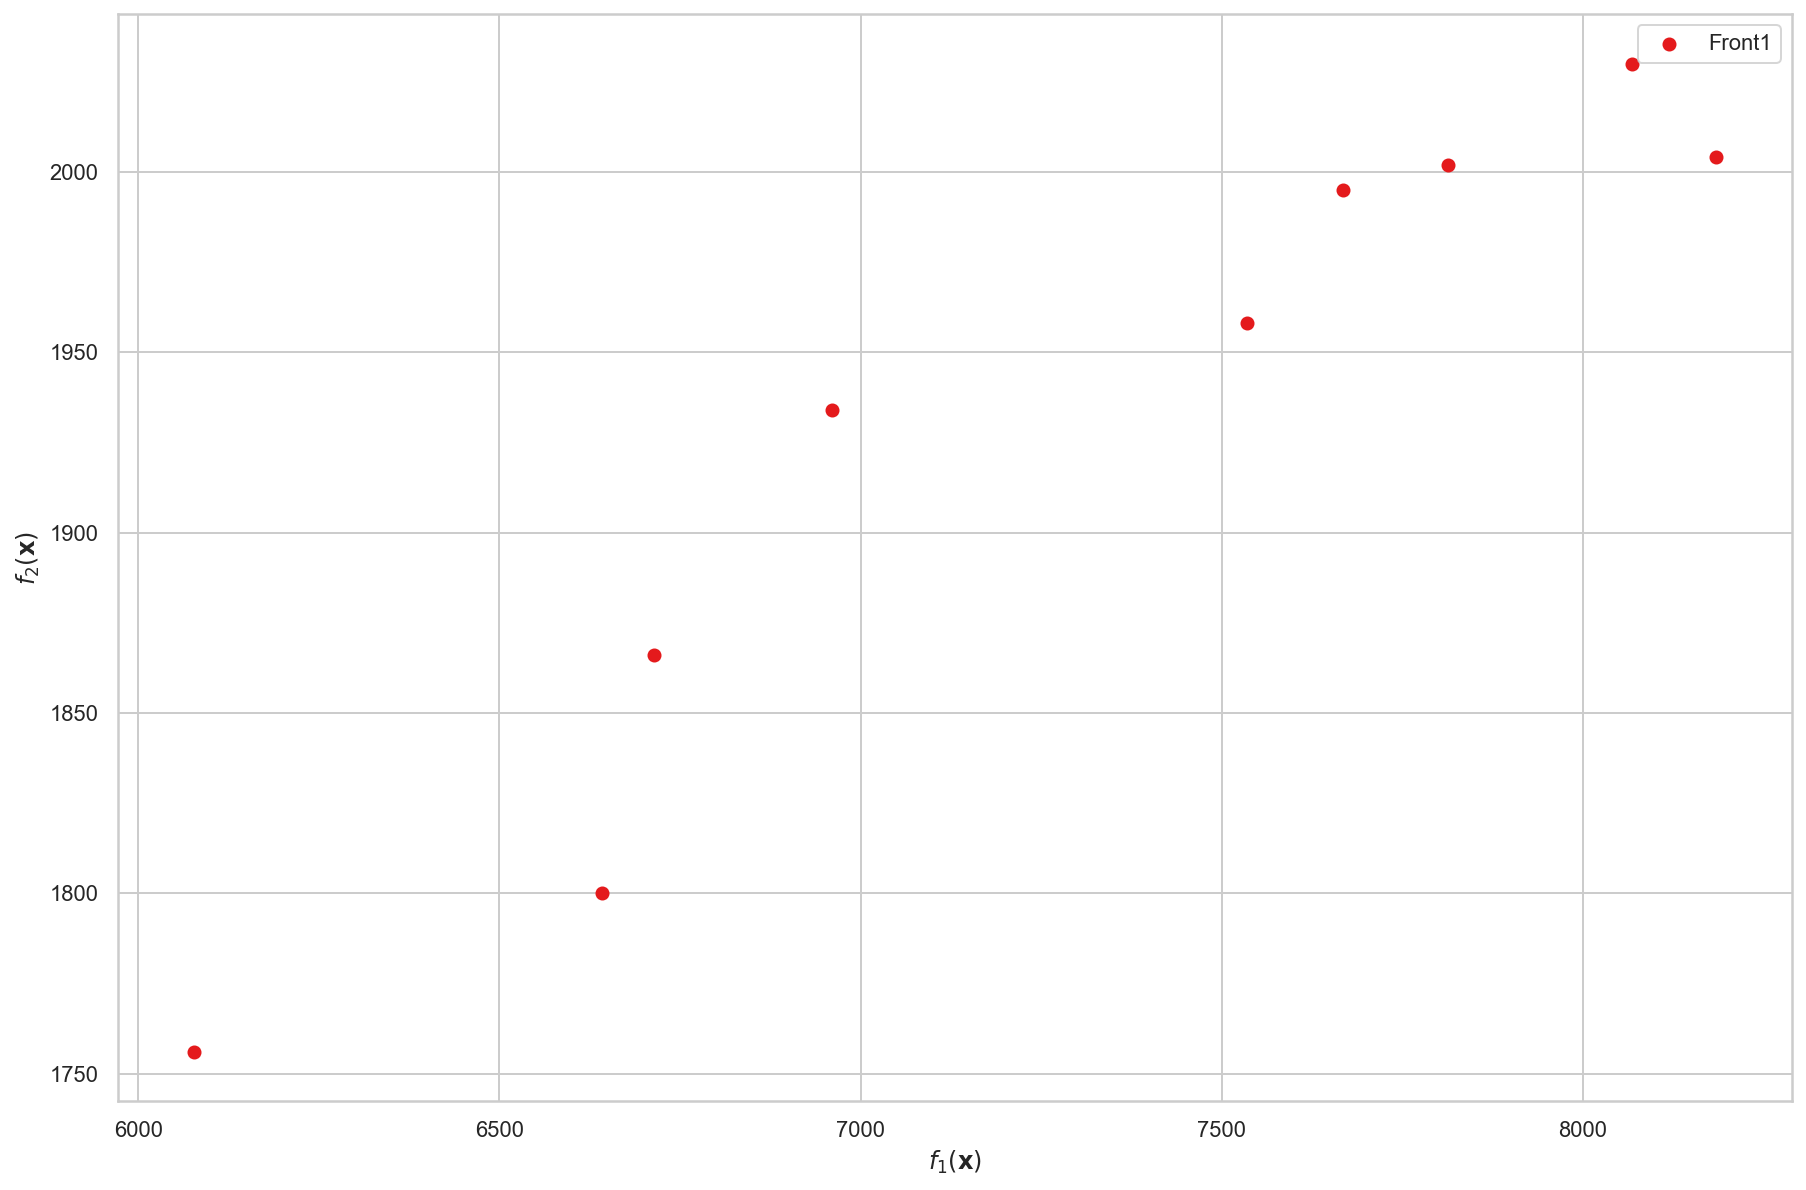

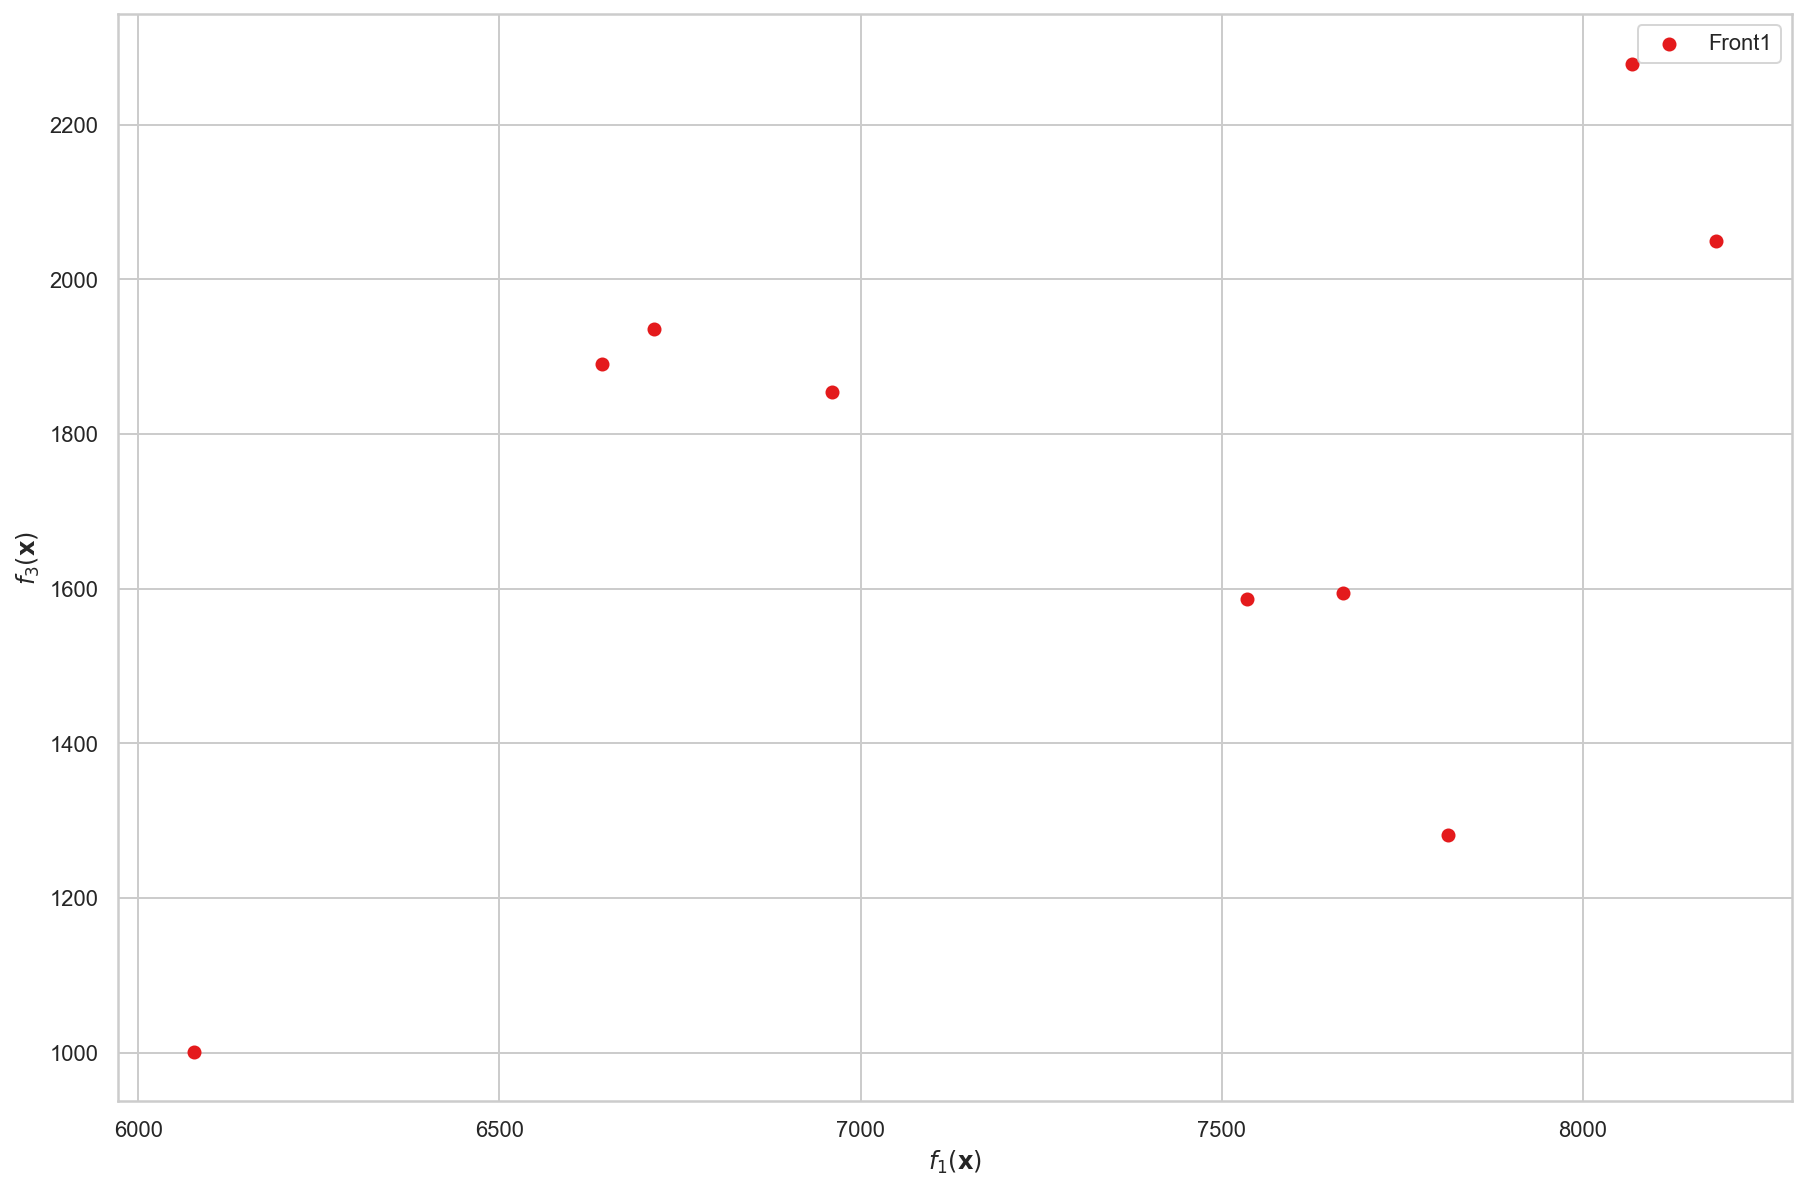

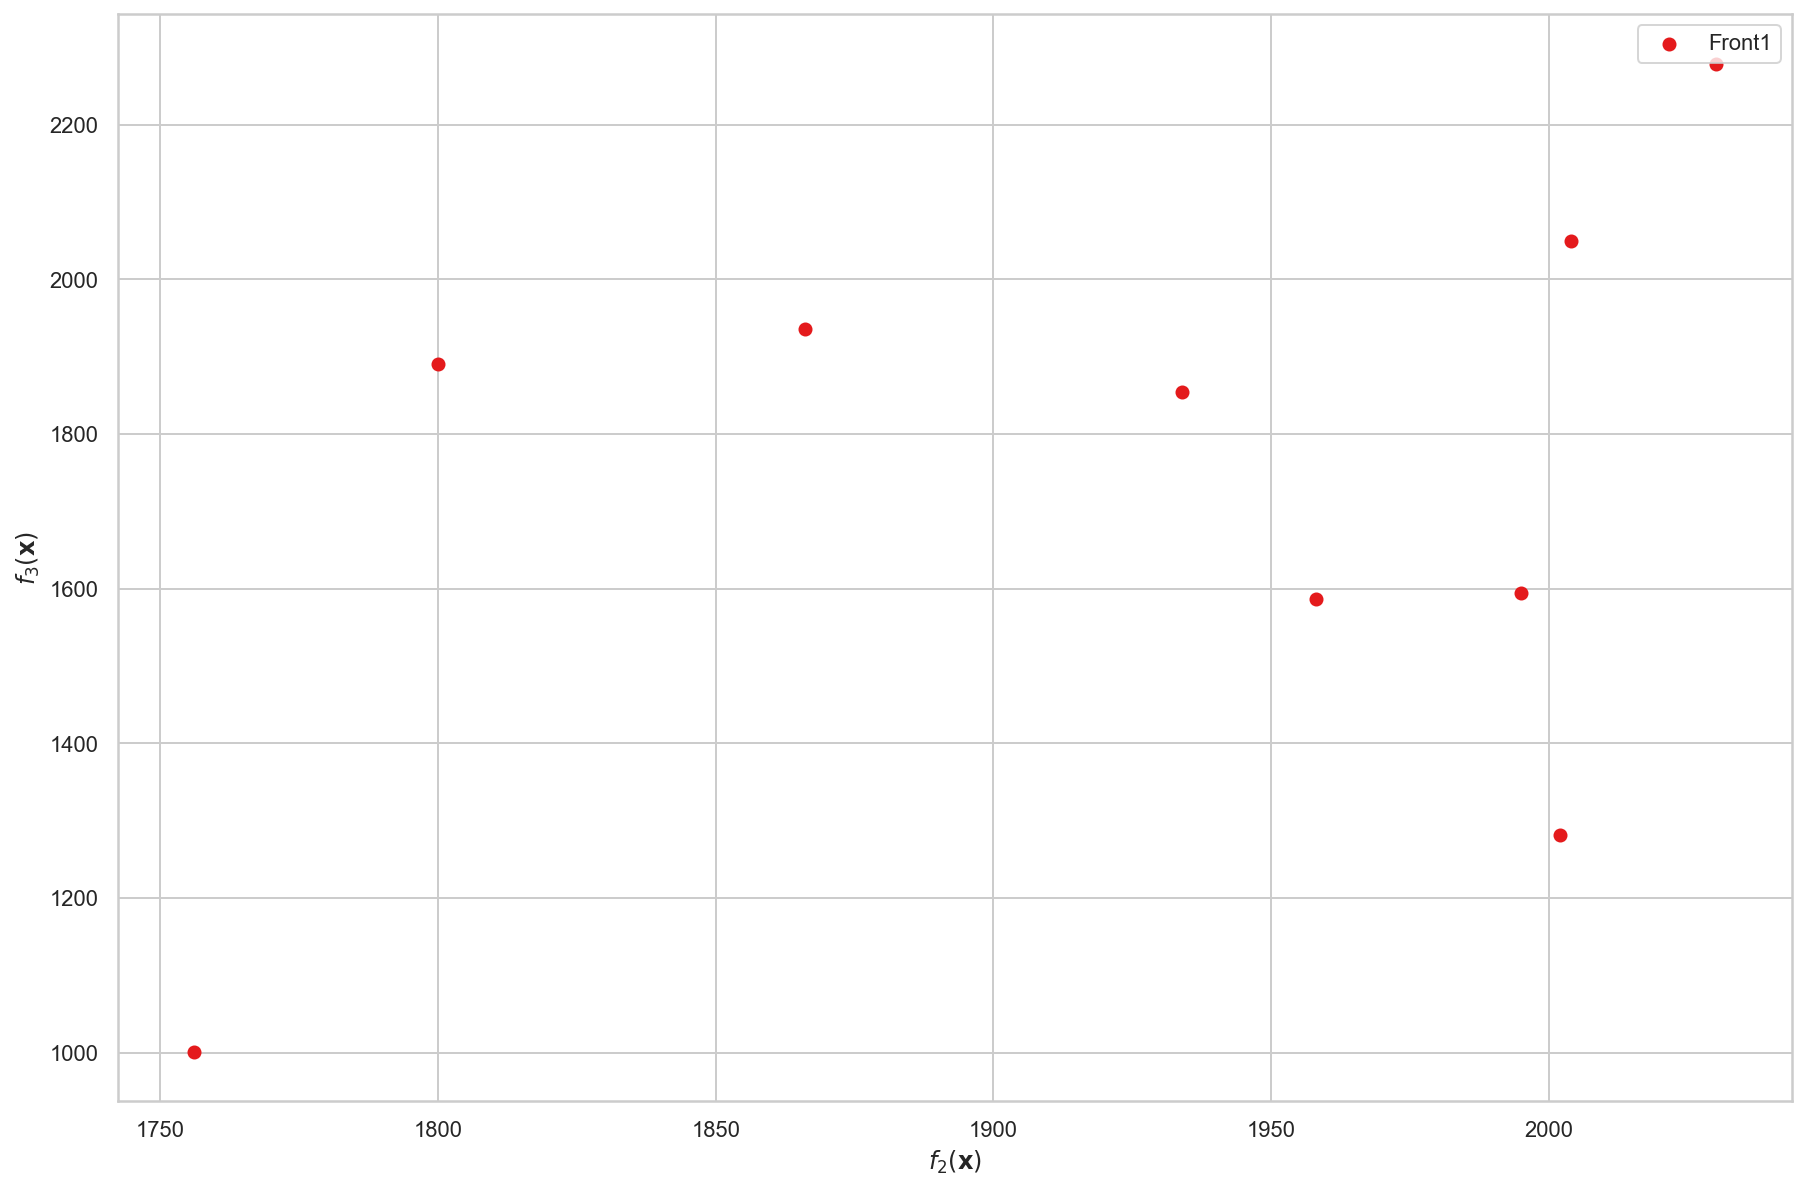

In [336]:
#file_name, m, pop_size, num_gen, mut_rate, xover_rate
instance = instance_create('jeu_100_25_1.txt', 3, 20, 10, .05, .8, 0)
%time res, logbook, fronts, stats = execute_EA(instance, verbose = False)

In [35]:
stats

{'instance_name': 'r_100_25_1',
 'sample_num': None,
 'xover_rate': 0.8,
 'mut_rate': 0.05,
 'pop_size': 100,
 'num_gen': 100,
 'n_kp': 3,
 'mean_f1': 18562.63959479016,
 'median_f1': 18425.0,
 'variance_f1': 8688658.867953734,
 'sample_size': 100,
 'min_f1': 13496.0,
 'max_f1': 23869.0,
 'mean_f2': 1356.13,
 'median_f2': 1343.0,
 'variance_f2': 50067.01310000001,
 'min_f2': 990,
 'max_f2': 1755,
 'mean_f3': 5020.28,
 'median_f3': 4886.5,
 'variance_f3': 1922374.1816000005,
 'min_f3': 2199,
 'max_f3': 7401}